In [1]:
import os
import shutil
from pathlib import Path

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
from keras.applications.vgg16 import preprocess_input

In [3]:
sns.set(font_scale=1.5)

In [4]:
"n02110806-basenji".split("-")

['n02110806', 'basenji']

In [5]:
"n02110806-basenji".split("-", 1)

['n02110806', 'basenji']

In [6]:
data_dir = "/Users/stanislasbocearov/Downloads/Images/"
width, height = 230, 230

### Get breed counts

In [7]:
breed_counts = []
for idx, folder in enumerate(os.listdir(data_dir)):
    if os.path.isdir(f'/Users/stanislasbocearov/Downloads/Images/{folder}'):
        _, breed = folder.split("-", 1)
        subdir = f"{data_dir}{folder}"
        breed_counts.append({"breed": breed, "folder": folder, "count": len(os.listdir(subdir))})

breed_counts = pd.DataFrame(breed_counts)
breed_counts = breed_counts.sort_values("count", ascending=True)

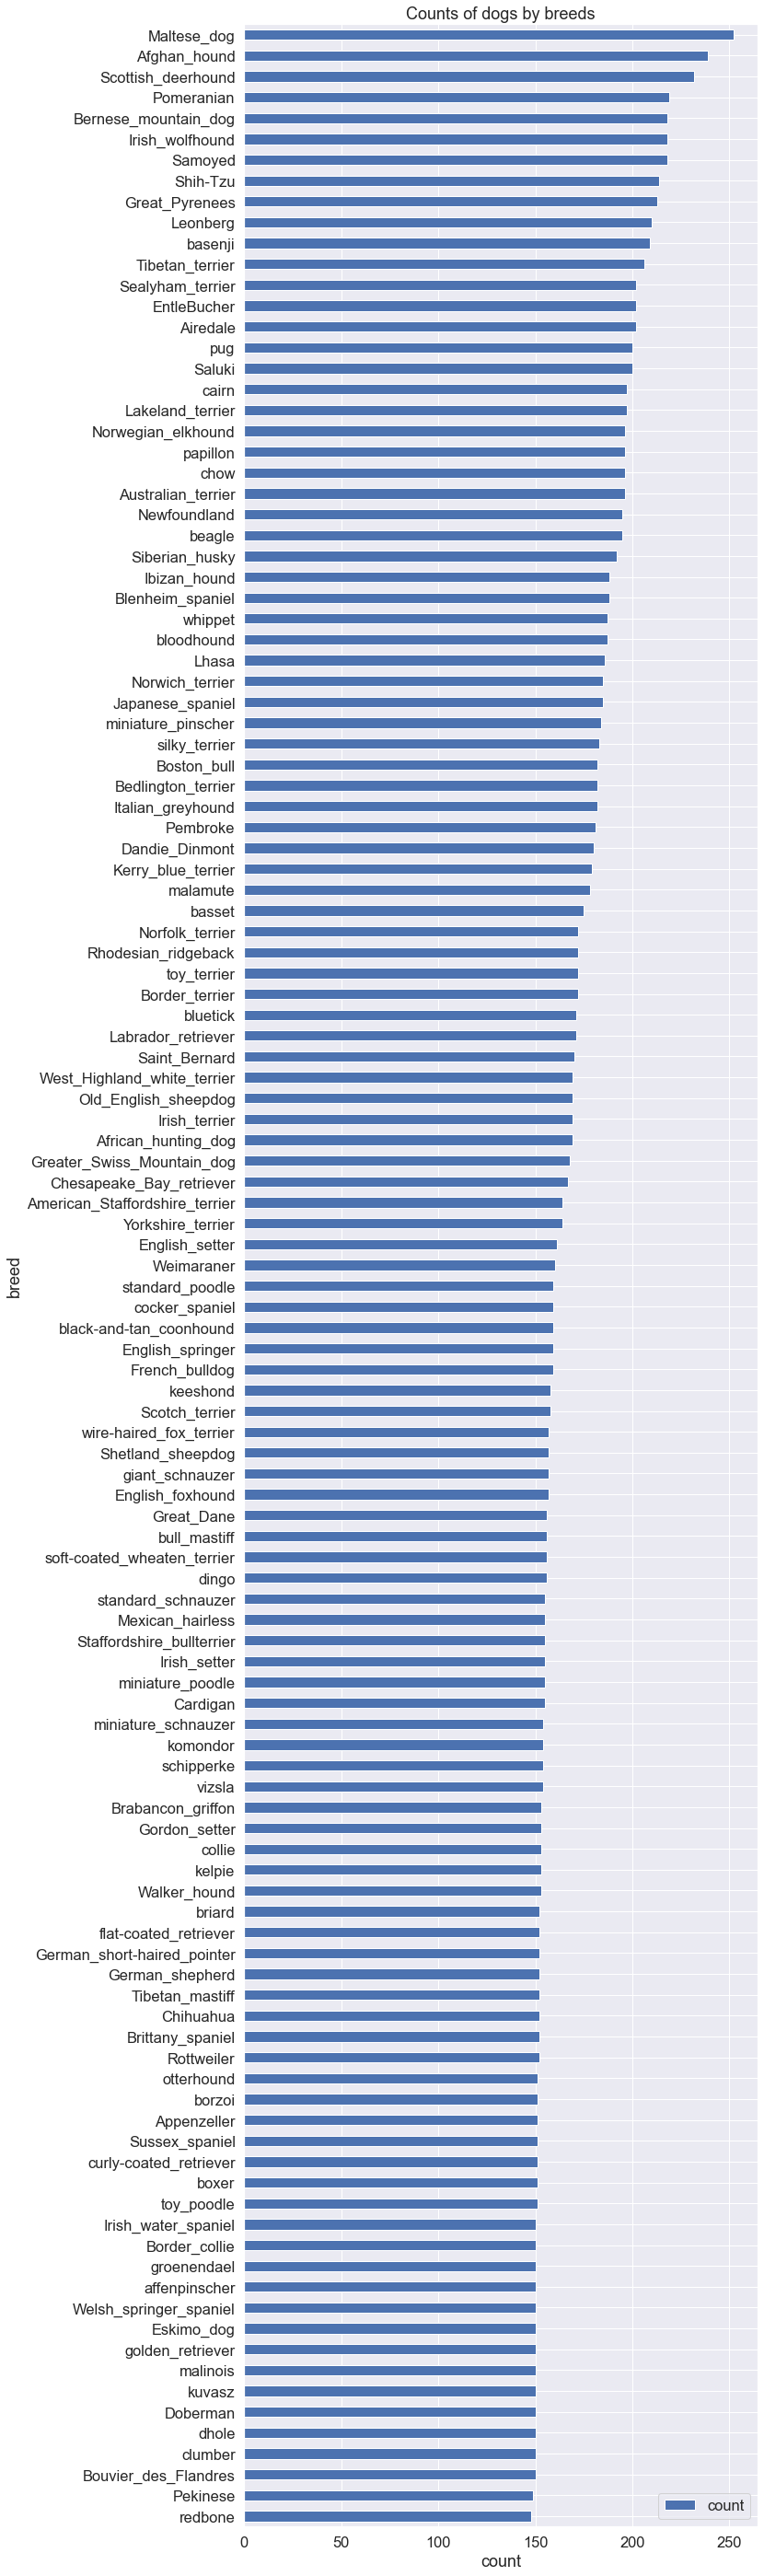

In [8]:
breed_counts.plot(kind='barh', x='breed', y='count', figsize=(10, 50), title="Counts of dogs by breeds")
plt.ylabel("breed")
_ = plt.xlabel("count")

### Get one example image of each breed for 20 most common breeds

In [9]:
breed_counts = breed_counts.sort_values("count", ascending=False).reset_index()

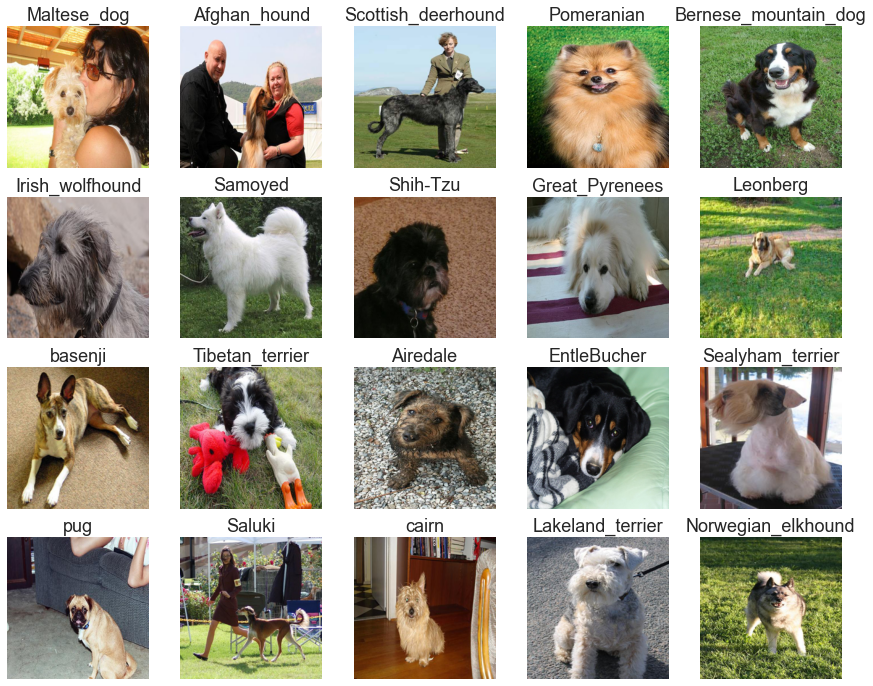

In [10]:
plt.figure(figsize=(15, 12))

for idx, row in breed_counts[:20].iterrows():
    folder = row.get("folder")
    breed = row.get("breed")
    subdir = f"{data_dir}{folder}"
    first_image = os.listdir(subdir)[42]
    first_image_path = f"{subdir}/{first_image}"
    img = Image.open(first_image_path)
    img_resized = img.resize((width, height))
    plt.subplot(4, 5, idx + 1)
    plt.imshow(img_resized)
    plt.title(breed)
    plt.axis('off')
    

### Take only the three most common breeds into directory /data/dogs-n_breeds and apply preprocessing

In [11]:
n_breeds = 3

In [12]:
breed_counts

index                 breed                          folder  count
0       38           Maltese_dog           n02085936-Maltese_dog    252
1      105          Afghan_hound          n02088094-Afghan_hound    239
2        1    Scottish_deerhound    n02092002-Scottish_deerhound    232
3      114            Pomeranian            n02112018-Pomeranian    219
4       56  Bernese_mountain_dog  n02107683-Bernese_mountain_dog    218
..     ...                   ...                             ...    ...
115     24              Doberman              n02107142-Doberman    150
116     26                 dhole                 n02115913-dhole    150
117    101               clumber               n02101556-clumber    150
118     21              Pekinese              n02086079-Pekinese    149
119     48               redbone               n02090379-redbone    148

[120 rows x 4 columns]

In [13]:
_, _, folder, _ = breed_counts.iloc[0].values

In [14]:
testimg_subdir = f"{data_dir}{folder}"

In [15]:
testimg_path = f"{testimg_subdir}/{os.listdir(testimg_subdir)[30]}"

In [16]:
testimg_path

'/Users/stanislasbocearov/Downloads/Images/n02085936-Maltese_dog/n02085936_7442.jpg'

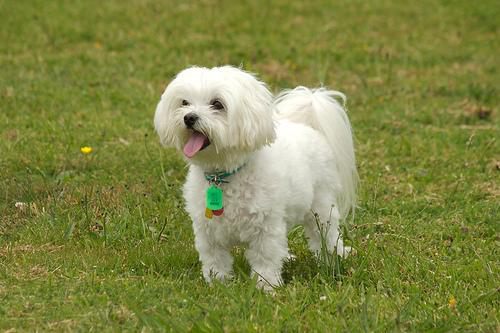

In [17]:
testimg = Image.open(testimg_path)
testimg

In [18]:
# convert to matrix
mat_img = np.array(testimg)

In [19]:
mat_img

array([[[119, 123,  49],
        [122, 126,  52],
        [123, 129,  55],
        ...,
        [107, 114,  44],
        [107, 114,  44],
        [107, 114,  44]],

       [[121, 125,  51],
        [123, 127,  53],
        [123, 129,  55],
        ...,
        [109, 116,  46],
        [109, 116,  46],
        [109, 116,  46]],

       [[124, 128,  54],
        [125, 129,  55],
        [123, 129,  55],
        ...,
        [109, 119,  46],
        [109, 119,  46],
        [109, 119,  46]],

       ...,

       [[122, 127,  47],
        [133, 138,  58],
        [141, 142,  66],
        ...,
        [129, 117,  57],
        [147, 135,  75],
        [158, 143,  86]],

       [[128, 133,  53],
        [132, 135,  58],
        [133, 134,  58],
        ...,
        [127, 117,  55],
        [142, 132,  71],
        [151, 139,  81]],

       [[127, 131,  54],
        [136, 139,  62],
        [141, 141,  67],
        ...,
        [124, 116,  53],
        [135, 127,  64],
        [143, 134,  75]]

In [20]:
mat_img.shape

(333, 500, 3)

In [21]:
# split image to three channels : r, g, b
mat_img_r = mat_img[:,:,0]
mat_img_g = mat_img[:,:,1]
mat_img_b = mat_img[:,:,2]

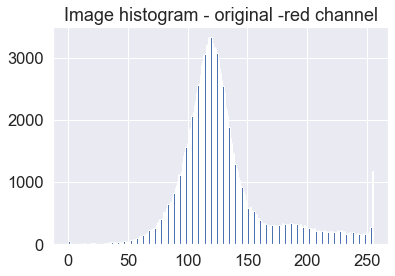

In [22]:
_ = plt.hist(mat_img_r.flatten(), bins=range(256))
_ = plt.title("Image histogram - original -red channel")

In [23]:
testimg_autocontrast = ImageOps.autocontrast(testimg)

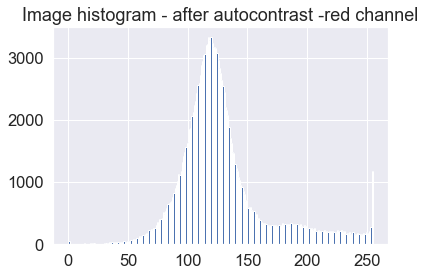

In [24]:
mat_img_autocontrast = np.array(testimg_autocontrast)
_ = plt.hist(mat_img_autocontrast[0:,0:,0].flatten(), bins=range(256))
_ = plt.title("Image histogram - after autocontrast -red channel")

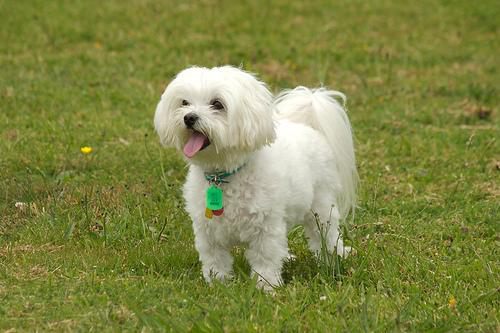

In [25]:
testimg_autocontrast

In [26]:
testimg_equa = ImageOps.equalize(testimg)

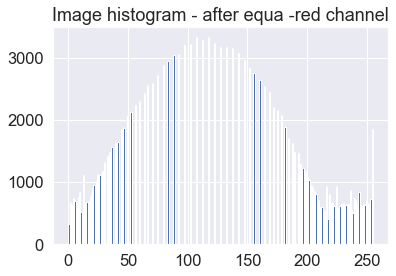

In [38]:
mat_img_equa = np.array(testimg_equa)
_ = plt.hist(mat_img_equa[0:,0:,0].flatten(), bins=range(256))
_ = plt.title("Image histogram - after equa -red channel")

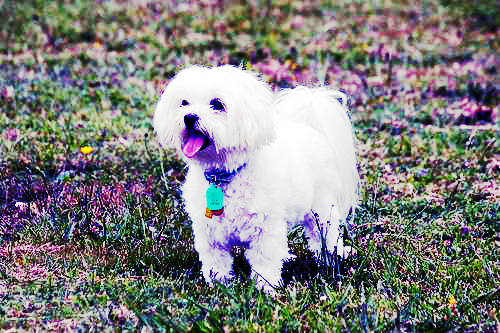

In [27]:
testimg_equa

In [28]:
testimg_median_noise_filter = testimg.filter(ImageFilter.MedianFilter(size=3))
# filter allows to blur pixels that behave like noise, with values very different from surroundings

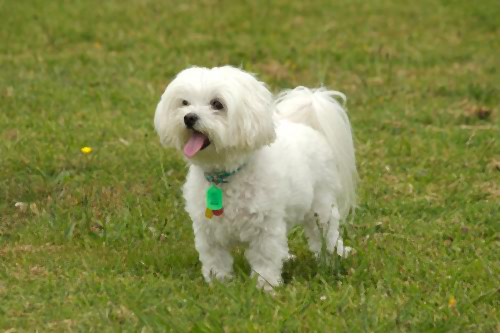

In [29]:
testimg_median_noise_filter

### Preprocessing done by the VGG16 preprocessor

In [30]:
mat_img_vgg16_preproc = preprocess_input(mat_img)

In [31]:
mat_img_vgg16_preproc.shape

(333, 500, 3)

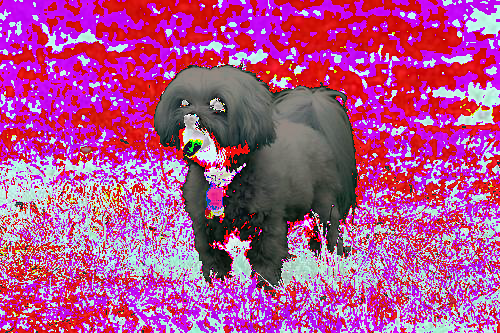

In [32]:
Image.fromarray(mat_img_vgg16_preproc.astype(np.uint8))

### We define the following preprocessing pipeline:

In [33]:
def preprocess(img):
    """Apply preproccessing filters. Note that resizing and data augmentation will be performed in Keras"""
    img = ImageOps.autocontrast(img)
    img = ImageOps.equalize(img)
    img = img.filter(ImageFilter.MedianFilter(size=3))
    return img
    

##### We might later test models with the VGG16 preprocessor, but for this initial preprocessing we will apply only basic preprocess

In [34]:
testimg_preprocessed = preprocess(testimg)

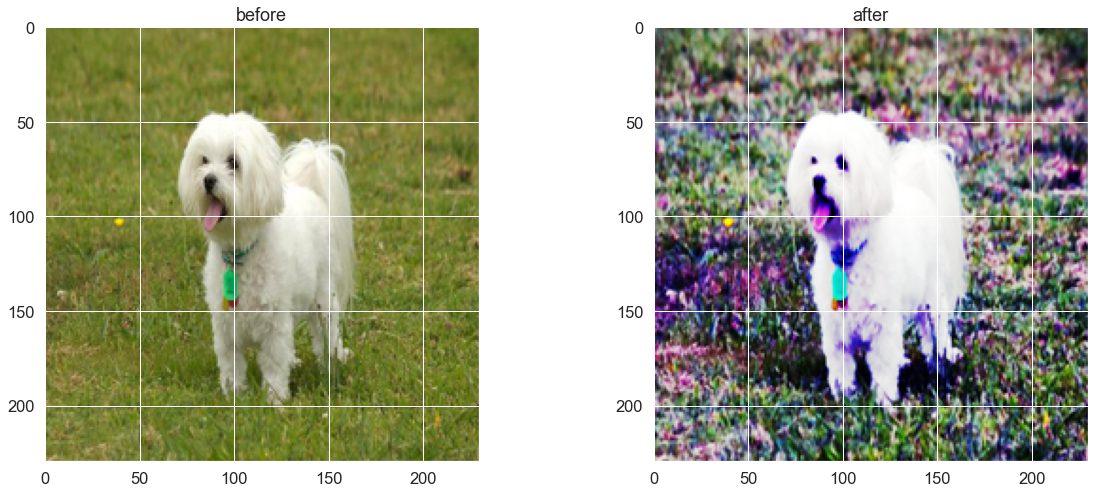

In [35]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
testimg_resized = testimg.resize((width, height))
plt.title("before")
plt.imshow(testimg_resized)

plt.subplot(1, 2, 2)
plt.title("after")
testimg_preprocessed_resized = preprocess(testimg).resize((width, height))
_ = plt.imshow(testimg_preprocessed_resized)

In [36]:
# small details are blurrred with focus on large scale features; contrast is adjusted and pixel values ranges are normalized

In [37]:
extract_dir = f"/Users/stanislasbocearov/Downloads/Images-extract-{n_breeds}"
Path(extract_dir).mkdir(parents=True, exist_ok=True)
Path(f"{extract_dir}-preproc").mkdir(parents=True, exist_ok=True)

for idx, row in breed_counts[:n_breeds].iterrows():
    folder = row.get("folder")
    breed = row.get("breed")
    for file in os.listdir(f"{data_dir}{folder}"):
        file_path = f"{data_dir}{folder}/{file}"
        new_file_path = f"{extract_dir}/{breed}/{file}"
        new_file_path_preproc = f"{extract_dir}-preproc/{breed}/{file}"
        
        Path(f"{extract_dir}/{breed}").mkdir(parents=True, exist_ok=True)
        Path(f"{extract_dir}-preproc/{breed}").mkdir(parents=True, exist_ok=True)
        
        img = Image.open(file_path)
        img_preproc = preprocess(img)
        
        img.save(new_file_path)
        img_preproc.save(new_file_path_preproc)